Predicting NFL Wins

I have been a fan of most sports growing up. You can find me watching most (if not all) NFL games on a given football Sunday. With recent legalization of sports gambling and DraftKings ads thrown in my face every 2 minutes, I started wondering the accuracy of Vegas spreads and whether other features could be introduced to make a stronger win predictions. 

My initial expectation of a succesful model is a model that can make a prediction with accuracy > 0.55 in pure win prediction. In gambling terms, "win rate" above 52% would be considered very successful (like in Casinos) and over a large samples profits could be garnered. 

There are many limitations with my data set. As you can see below, I only included team stats from previous 5 seasons and gambling stats. However, in real world, there are many more features going down to individual players, staff and coaches. I plan on adding and growing my data set to include more dimensions over time, but due to webscraping, time and performance limitations, I decided to limit the stats to team stats. 
The spread (or over/under lines) are most likely calulated using all (and more) features that I used, so it is reasonable to expect some correlation with betting odds and team stats. 

I hope to capture a few things with my model. Firstly, I want to be able to predict wins given the betting odds and team stats. I also want to be able to withdraw patterns from games that contradicted the betting odds. 

In [109]:
import pandas as pd
import glob
import os
import sys
import subprocess


# subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
from sklearn.preprocessing import StandardScaler
import numpy as np

import matplotlib.pyplot as plt

We load our first data set into a DataFrame. This data set contains NFL game info, the spread between the game as well as over/under line for each game. The spread (or over_under_lines) is the most important feature and null values in these columns are hard to replace. Also, since the games without these availale data tend to be from older games (pre 1978), excluding some of these data points should not impact the outcome too much. I think there may be bigger concerns with including older games in the data due to rule changes and the evolution of the game. I plan on cleaning up the data and training the model based on different time periods of the stats to see look for a potential correlation.

In [110]:
spread_df = pd.read_csv("data/spreadspoke_scores.csv")
# spread_df = spread_df.dropna(subset=['spread_favorite'])  
# spread_df = spread_df.dropna(subset=['over_under_line'])  
spread_df = spread_df[spread_df['schedule_season'] >= 1978].reset_index(drop=True)

print(spread_df.columns)

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'stadium',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'weather_detail'],
      dtype='object')


The data that I was able to secure for team's season's stat only includes offensive stats. However, defensive stats could serve as an important feature in determining wins, so I calculated points scored against every team for every season below.

In [111]:
import pandas as pd

papf_df = pd.read_csv("data/spreadspoke_scores.csv")
papf_df = papf_df[papf_df['schedule_season'] >= 1978].reset_index(drop=True)
papf_df = papf_df[papf_df['schedule_playoff'] != True].reset_index(drop=True)

points_for = {}
points_against = {}

for index, row in papf_df.iterrows():
    home_team = row['team_home']
    away_team = row['team_away']
    home_score = row['score_home']
    away_score = row['score_away']
    season = row['schedule_season']
    
    if (season, home_team) not in points_for:
        points_for[(season, home_team)] = 0
    points_for[(season, home_team)] += home_score
    
    if (season, away_team) not in points_for:
        points_for[(season, away_team)] = 0
    points_for[(season, away_team)] += away_score

    if (season, home_team) not in points_against:
        points_against[(season, home_team)] = 0
    points_against[(season, home_team)] += away_score

    if (season, away_team) not in points_against:
        points_against[(season, away_team)] = 0
    points_against[(season, away_team)] += home_score

# Convert the dictionaries to DataFrames for easier inspection
points_for_df = pd.DataFrame(list(points_for.items()), columns=['Season_Team', 'PF'])
points_against_df = pd.DataFrame(list(points_against.items()), columns=['Season_Team', 'PA'])

# Split 'Season_Team' into separate 'Season' and 'Team' columns
points_for_df[['Season', 'Team']] = pd.DataFrame(points_for_df['Season_Team'].tolist(), index=points_for_df.index)
points_against_df[['Season', 'Team']] = pd.DataFrame(points_against_df['Season_Team'].tolist(), index=points_against_df.index)

points_for_df = points_for_df.drop(columns=['Season_Team'])
points_against_df = points_against_df.drop(columns=['Season_Team'])

# Merge Points For and Points Against for the final summary
pa_pf_summary = pd.merge(points_for_df, points_against_df, on=['Season', 'Team'])

pa_pf_summary.head()


,PF,Season,Team,PA
0,241.0,1978,Tampa Bay Buccaneers,259.0
1,264.0,1978,New York Giants,298.0
2,240.0,1978,Atlanta Falcons,290.0
3,283.0,1978,Houston Oilers,298.0
4,302.0,1978,Buffalo Bills,354.0


Next, I load all of the team stats (separated by season) into a dictionary to utilize later in combinding the tables,

In [112]:
# Load the team stats for each season
teamstat_csv = glob.glob(os.path.join("data/team stats", "*.csv"))
season_stat = {}
correct_headers = [
    'Rk', 'Tm', 'G', 'PF', 'Tot_Yds', 'Ply', 'Y/P', 'TO', 'FL', '1stD',
    'Cmp', 'Att', 'Passing_Yds', 'Passing_TD', 'Passing_Int', 'NY/A', 'Passing_1stD',
    'Rushing_Att', 'Rushing_Yds', 'Rushing_TD', 'Y/A', 'Rushing_1stD', 'Pen', 
    'Pen_Yds', '1stPy', 'Sc%', 'TO%'
]

for csv in teamstat_csv:
    year = os.path.splitext(os.path.basename(csv))[0]
    df = pd.read_csv(csv, header=1)
        
    if len(df.columns) > len(correct_headers):
        df = df.iloc[:, :len(correct_headers)]  
        
    df.columns = correct_headers
    
    season_stat[int(year)] = df


Next, we remove some unnecessary features from the table. Features such as total yards, total plays, yards per play are unnecessary since they are derived from existing columns in the table. By same logic, pass and rush attempts can be ommited as well.

In [113]:
columns_to_drop = ['Rk', 'Tot_Yds', 'Ply', 'Y/P', '1stD', 'Cmp', 'Rushing_Att']

for year, df in season_stat.items():
    season_stat[year] = df.drop(columns=columns_to_drop)


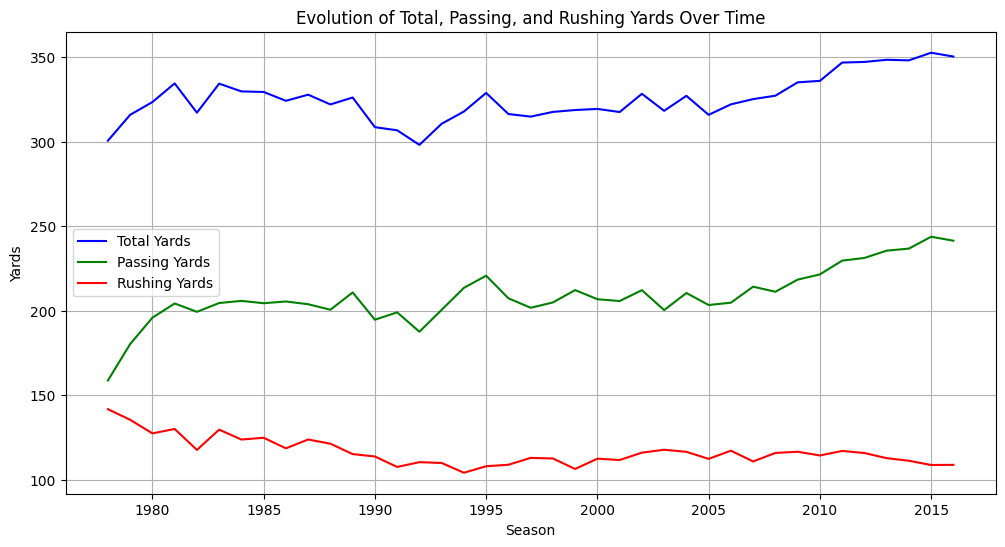

In [114]:
# Aggregate stats for each season
season_totals = []

for year, df in season_stat.items():
    total_games = df['G'].sum()
    season_totals.append({
        'Season': year,
        'Passing_Yards': df['Passing_Yds'].sum()/total_games,
        'Rushing_Yards': df['Rushing_Yds'].sum()/total_games,
        'Total_Yards':df['Passing_Yds'].sum()/total_games + df['Rushing_Yds'].sum()/total_games,
    })

# Convert to DataFrame
season_df = pd.DataFrame(season_totals).sort_values(by='Season')

# Plot the trends
plt.figure(figsize=(12, 6))
plt.plot(season_df['Season'], season_df['Passing_Yards'] + season_df['Rushing_Yards'], label='Total Yards', color='blue')
plt.plot(season_df['Season'], season_df['Passing_Yards'], label='Passing Yards', color='green')
plt.plot(season_df['Season'], season_df['Rushing_Yards'], label='Rushing Yards', color='red')

plt.xlabel("Season")
plt.ylabel("Yards")
plt.title("Evolution of Total, Passing, and Rushing Yards Over Time")
plt.legend()
plt.grid()
plt.show()

In [115]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Example: Loop through each season's stats DataFrame
for year, df in season_stat.items():
    # Calculate league mean and standard deviation for each stat (ignoring 'Tm')
    league_mean = df.drop(columns=['Tm']).mean()  # Calculate mean for each stat across all teams in the season
    league_std = df.drop(columns=['Tm']).std()  # Calculate standard deviation for each stat across all teams in the season
    # Normalize the stats for each team in that season
    for stat in df.columns:
        if stat not in ['Tm']:  # Exclude the team column
            df[stat] = (df[stat] - league_mean[stat]) / league_std[stat]


G                 16.000000
PF               293.321429
TO                40.571429
FL                17.750000
Att              422.464286
Passing_Yds     2541.357143
Passing_TD        16.714286
Passing_Int       22.821429
NY/A               5.532143
Passing_1stD     132.892857
Rushing_Yds     2269.285714
Rushing_TD        16.214286
Y/A                3.946429
Rushing_1stD     123.714286
Pen              107.500000
Pen_Yds          923.571429
1stPy             25.821429
Sc%                     NaN
TO%                     NaN
dtype: float64
G                 16.000000
PF               321.035714
TO                38.250000
FL                16.928571
Att              463.535714
Passing_Yds     2886.035714
Passing_TD        19.214286
Passing_Int       21.321429
NY/A               5.735714
Passing_1stD     148.178571
Rushing_Yds     2169.035714
Rushing_TD        17.392857
Y/A                3.996429
Rushing_1stD     122.678571
Pen              102.500000
Pen_Yds          870.714286
1stPy

Normalized average team stats in a time series shows a very intersting trend. Rushing yards have decreased dramatically until the early 1990s where the passing yards seem to increase every season. The drastic shift starting around 1994 makes sense, since this is when the NFL implemeted a few rules to encourage passing offense in general.

Analyzing this data set seems to suggest to exclude game data from before 1995 season, since the offense trend is almost oppsite in modern American Football. We will train the model with both datasets where one includes all the games from pre 1995 and the other does not.



In [116]:
import pandas as pd

spread_df = pd.read_csv("data/spreadspoke_scores.csv")
spread_df = spread_df[spread_df['schedule_season'] >= 1978].reset_index(drop=True)
spread_df = spread_df[spread_df['schedule_playoff'] != True].reset_index(drop=True)

points_for = {}
points_against = {}

for index, row in spread_df.iterrows():
    home_team = row['team_home']
    away_team = row['team_away']
    home_score = row['score_home']
    away_score = row['score_away']
    season = row['schedule_season']
    
    if (season, home_team) not in points_for:
        points_for[(season, home_team)] = 0
    points_for[(season, home_team)] += home_score
    
    if (season, away_team) not in points_for:
        points_for[(season, away_team)] = 0
    points_for[(season, away_team)] += away_score

    if (season, home_team) not in points_against:
        points_against[(season, home_team)] = 0
    points_against[(season, home_team)] += away_score

    if (season, away_team) not in points_against:
        points_against[(season, away_team)] = 0
    points_against[(season, away_team)] += home_score

# Convert the dictionaries to DataFrames for easier inspection
points_for_df = pd.DataFrame(list(points_for.items()), columns=['Season_Team', 'PF'])
points_against_df = pd.DataFrame(list(points_against.items()), columns=['Season_Team', 'PA'])

# Split 'Season_Team' into separate 'Season' and 'Team' columns
points_for_df[['Season', 'Team']] = pd.DataFrame(points_for_df['Season_Team'].tolist(), index=points_for_df.index)
points_against_df[['Season', 'Team']] = pd.DataFrame(points_against_df['Season_Team'].tolist(), index=points_against_df.index)

points_for_df = points_for_df.drop(columns=['Season_Team'])
points_against_df = points_against_df.drop(columns=['Season_Team'])

# Merge Points For and Points Against for the final summary
pa_pf_summary = pd.merge(points_for_df, points_against_df, on=['Season', 'Team'])

pa_pf_summary.head()


,PF,Season,Team,PA
0,241.0,1978,Tampa Bay Buccaneers,259.0
1,264.0,1978,New York Giants,298.0
2,240.0,1978,Atlanta Falcons,290.0
3,283.0,1978,Houston Oilers,298.0
4,302.0,1978,Buffalo Bills,354.0


In [117]:
import pandas as pd

# Load the team stats data (already loaded previously as season_stat)
team_stats_list = []

# Convert the team stats data from season_stat to a single DataFrame
for year, df in season_stat.items():
    # Filter relevant columns (Season, Team, PF, PA)
    df_filtered = df[['Tm', 'PF']]
    df_filtered['Season'] = year  # Add season as a column
    df_filtered['Team'] = df_filtered['Tm']  # Rename 'Tm' to 'Team' for consistency

    # Append the filtered DataFrame to the list
    team_stats_list.append(df_filtered)

# Combine all the DataFrames into a single DataFrame
team_stats_combined = pd.concat(team_stats_list, ignore_index=True)
print(team_stats_combined)
# Merge Points For (PF) from both datasets to verify they match
merged_df = pd.merge(pa_pf_summary, team_stats_combined[['Season', 'Team', 'PF']], on=['Season', 'Team'], how='left', suffixes=('_calculated', '_team_stat'))

# Explicitly print PF values from both datasets to compare
print("PF from weather-derived data:")
print(f'{merged_df[['Season', 'Team', 'PF_calculated']].head()}, {merged_df[['Season', 'Team', 'PF_team_stat']].head()}')

print("\nPF from team stats data:")
print(merged_df[['Season', 'Team', 'PF_team_stat']].head())

# Check if Points For (PF) match
pf_check = (merged_df['PF_calculated'] == merged_df['PF_team_stat']).all()

# Print the check result
print(f"\nPoints For are identical between both datasets: {pf_check}")

# If they match, we can now merge the Points Against (PA) as well
if pf_check:
    # Merge Points Against (PA) with team stats
    merged_df = pd.merge(merged_df, team_stats_combined[['Season', 'Team', 'PA']], on=['Season', 'Team'], how='left')

    # Add 'Points_Away' as Points Against for away teams
    merged_df['Points_Away'] = merged_df['PA']

    # Print the final merged DataFrame with Points For, Points Against, and Points Away
    print("\nFinal merged DataFrame with Points For, Points Against, and Points Away:")
    print(merged_df[['Season', 'Team', 'PF_calculated', 'PA', 'Points_Away']].head())
else:
    print("Points For do not match. Please investigate the discrepancy.")


                        Tm        PF  Season                  Team
0           Dallas Cowboys  1.891935    1978        Dallas Cowboys
1           Miami Dolphins  1.641565    1978        Miami Dolphins
2            New York Jets  1.370330    1978         New York Jets
3     New England Patriots  1.349466    1978  New England Patriots
4      Pittsburgh Steelers  1.307738    1978   Pittsburgh Steelers
...                    ...       ...     ...                   ...
1164        Houston Texans -1.294160    2016        Houston Texans
1165         Chicago Bears -1.294160    2016         Chicago Bears
1166         New York Jets -1.354772    2016         New York Jets
1167      Cleveland Browns -1.521455    2016      Cleveland Browns
1168      Los Angeles Rams -2.127574    2016      Los Angeles Rams

[1169 rows x 4 columns]
PF from weather-derived data:
   Season                  Team  PF_calculated
0    1978  Tampa Bay Buccaneers          241.0
1    1978       New York Giants          264.0


C:\Users\Will\AppData\Local\Temp\ipykernel_9852\717808703.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Season'] = year  # Add season as a column
C:\Users\Will\AppData\Local\Temp\ipykernel_9852\717808703.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Team'] = df_filtered['Tm']  # Rename 'Tm' to 'Team' for consistency
C:\Users\Will\AppData\Local\Temp\ipykernel_9852\717808703.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram